In [1]:
#importing utilities
import os
import sys
from datetime import datetime

#importing pytorch libraries
import torch
from numpy.core.setup_common import fname2def
from torch import nn
from torch.nn import init
from torch import autograd
from torch.utils.data import DataLoader
import torch.nn.functional as F

#importing data science libraries including pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

import pdb

In [2]:
df_torch = pd.read_csv("./creditcard.csv")
x = df_torch.Class.value_counts()
#df_torch = df.drop('Class', axis=1)
print(x)
print(df_torch.shape)

numeric_attr_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

numeric_attr = df_torch[numeric_attr_names] + 1e-3

df_torch_normalized = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())
# print(df_torch_normalized)
Class = df_torch_normalized.Class.values
print(Class)

0    284315
1       492
Name: Class, dtype: int64
(284807, 31)
[ 0.  0.  0. ...,  0.  0.  0.]


In [3]:
# conclusion: Dataset is highly unbalanced
# Here we want to check, how explanatory variables are affecting response variable(type of class)
print("Fraud") # only 492 counts for fraudulant cases
print(df_torch_normalized.Time[df_torch_normalized.Class==1].describe())
print()
print("Normal") # large number of counts for non-fraudulant cases
print(df_torch_normalized.Time[df_torch_normalized.Class==0].describe())

Fraud
count    492.000000
mean       0.467306
std        0.276838
min        0.002350
25%        0.238677
50%        0.437338
75%        0.743570
max        0.985856
Name: Time, dtype: float64

Normal
count    284315.000000
mean          0.548858
std           0.274804
min           0.000000
25%           0.313846
50%           0.490248
75%           0.806363
max           1.000000
Name: Time, dtype: float64


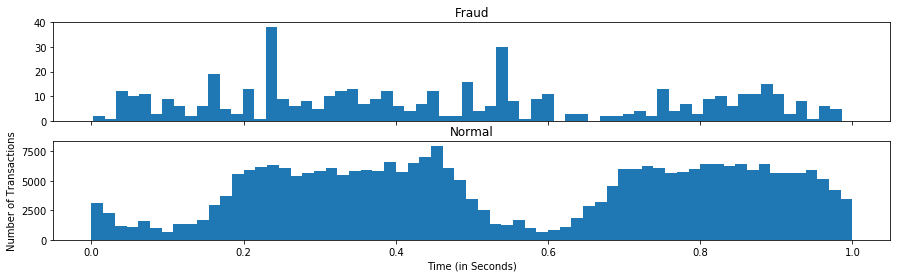

In [4]:
# returns a figure and two subplots stored in ax1 and ax2, respectively
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,4))
bins = 65

ax1.hist(df_torch_normalized.Time[df_torch_normalized.Class==1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df_torch_normalized.Time[df_torch_normalized.Class==0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

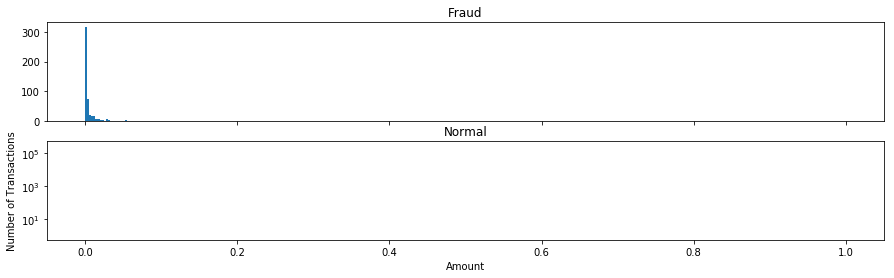

In [5]:
# returns a figure and two subplots stored in ax1 and ax2, respectively
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,4))
bins = 30

ax1.hist(df_torch_normalized.Amount[df_torch_normalized.Class==1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df_torch_normalized.Amount[df_torch_normalized.Class==0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')

# takes the value between (-1,1).
# log or ln because when a variable spans several orders of magnitude,
# it is often easier on the eyes (and more informative) to visualize it on the log scale.
plt.yscale('log')
plt.show()

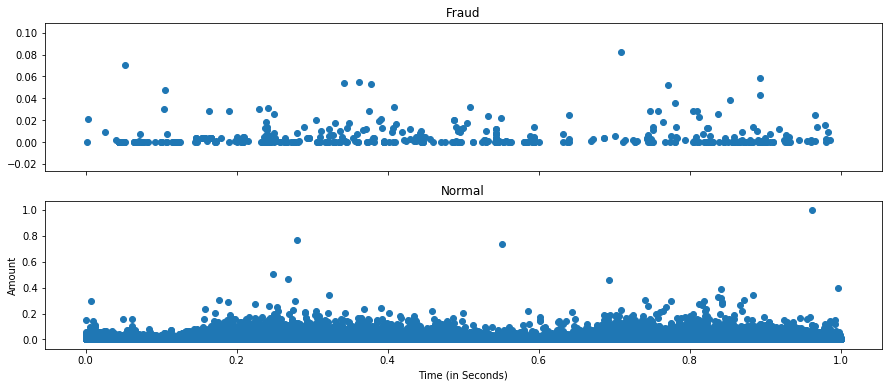

In [6]:
#compare Time with Amount for both the cases
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,6))

ax1.scatter(df_torch_normalized.Time[df_torch_normalized.Class == 1], df_torch_normalized.Amount[df_torch_normalized.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df_torch_normalized.Time[df_torch_normalized.Class == 0], df_torch_normalized.Amount[df_torch_normalized.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show() #somehow not too useful seeing from the distribution of data points

/home/samkit/anaconda3/envs/deep-learning/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/samkit/anaconda3/envs/deep-learning/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


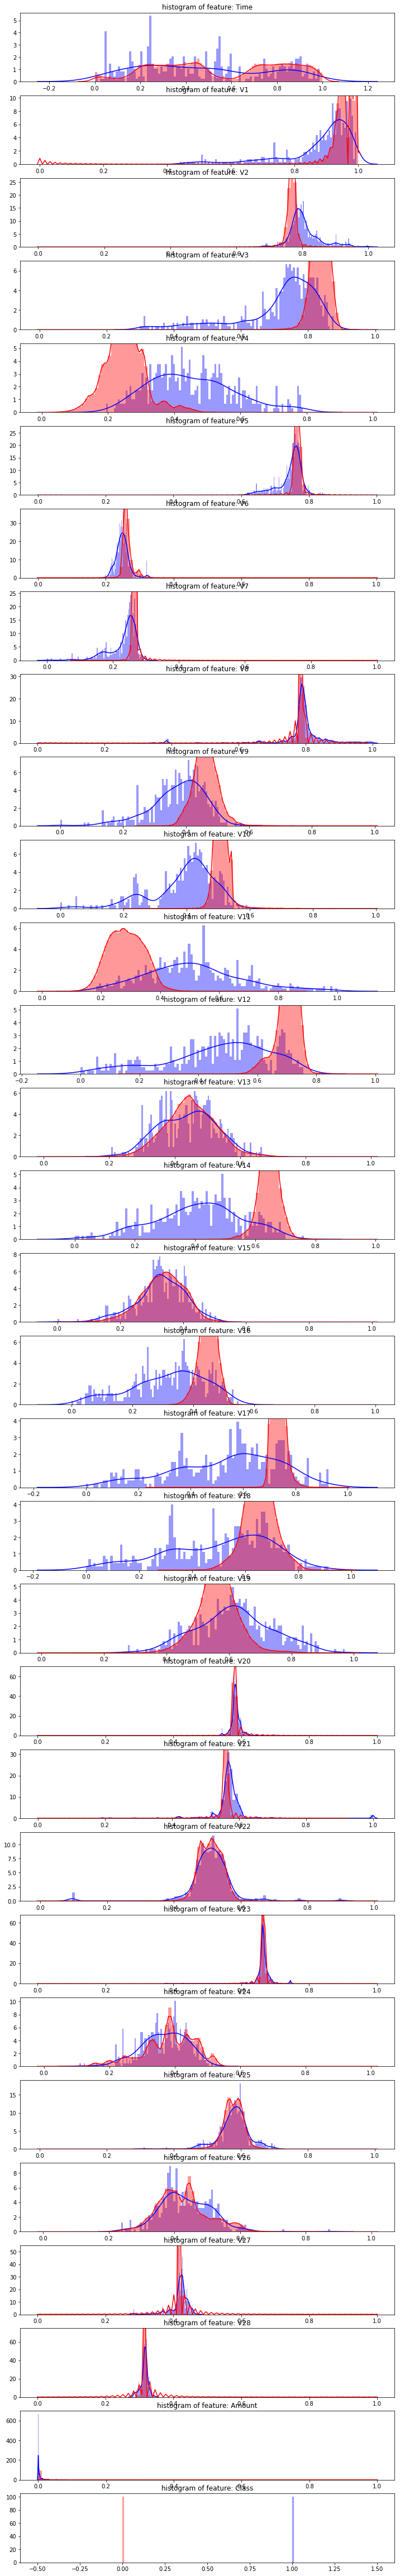

In [7]:
# let's plot each of the feature to analyse even further
plt.figure(figsize=(12,28*3))
gs = gridspec.GridSpec(31, 1) # creating grid with row = 28 for each feature, column = 1

# i = index, cn = to track the elements in list consisting column names
for i, cn in enumerate(df_torch_normalized[numeric_attr_names]):
    ax = plt.subplot(gs[i])
    # Plot a historgram and kernel density estimate
    sns.distplot(df_torch_normalized[cn][df_torch_normalized.Class == 1], bins=100, color='b') # e.g, Class==1 in feature = V1, so on..
    sns.distplot(df_torch_normalized[cn][df_torch_normalized.Class == 0], bins=100, color='r') # e.g, Class==0 in feature = V1, so on..
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# #Drop all of the features that have very similar distributions between the two types of transactions
# df = df.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8', 'Amount', 'Time', 'Class'], axis = 1)

In [8]:
# append 'Class'
numeric_attr_vis = df_torch_normalized.copy()
numeric_attr_vis['Class'] = Class

In [9]:
USE_CUDA = False
# setting up the seed
seed_value = 1234
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value)  # set pytorch seed GPU

# implementation of the encoder
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()

        # layer 1 - in 17, out 14
        self.encoder_L1 = nn.Linear(in_features=31, out_features=25, bias=True) # adding linearity
        nn.init.xavier_uniform(self.encoder_L1.weight) #initialize weights
        self.encoder_activation_L1 = nn.ReLU()

        # layer 2 - in 14, out 10
        self.encoder_L2 = nn.Linear(25, 20, bias=True)
        nn.init.xavier_uniform(self.encoder_L2.weight)
        self.encoder_activation_L2 = nn.Tanh()

        # layer 3 - in 10, out 5
        self.encoder_L3 = nn.Linear(20, 15, bias=True)
        nn.init.xavier_uniform(self.encoder_L3.weight)
        self.encoder_activation_L3 = nn.Tanh()

        # layer 4 - in 5, out 3
        self.encoder_L4 = nn.Linear(15, 10, bias=True)
        nn.init.xavier_uniform(self.encoder_L4.weight)
        self.encoder_activation_L4 = nn.Tanh()

        # layer 5 - in 5, out 3
        self.encoder_L5 = nn.Linear(10, 5, bias = True) # adding linearity
        nn.init.xavier_uniform(self.encoder_L5.weight) #initialize weights
        self.encoder_activation_L5 = nn.Tanh()

        # init dropout layer with probability p
        # self.dropout = nn.Dropout(p=0.4, inplace=True)

    def forward(self, x):
        # define forward pass
        x = self.encoder_activation_L1((self.encoder_L1(x)))
        x = self.encoder_activation_L2((self.encoder_L2(x)))
        x = self.encoder_activation_L3((self.encoder_L3(x)))
        x = self.encoder_activation_L4((self.encoder_L4(x)))
        x = self.encoder_activation_L5(self.encoder_L5(x))
        return x

# init training network classes / architectures
encoder_train = encoder()

# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20180320-18:54:12] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=31, out_features=25)
  (encoder_activation_L1): ReLU()
  (encoder_L2): Linear(in_features=25, out_features=20)
  (encoder_activation_L2): Tanh()
  (encoder_L3): Linear(in_features=20, out_features=15)
  (encoder_activation_L3): Tanh()
  (encoder_L4): Linear(in_features=15, out_features=10)
  (encoder_activation_L4): Tanh()
  (encoder_L5): Linear(in_features=10, out_features=5)
  (encoder_activation_L5): Tanh()
)



In [10]:
# implementation of the encoder
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()

        # layer 1 - in 3, out 5
        self.decoder_L1 = nn.Linear(in_features=5, out_features=10, bias=True) # adding linearity
        nn.init.xavier_uniform(self.decoder_L1.weight) #initialize weights
        self.decoder_activation_L1 = nn.Tanh()

        # layer 2 - in 5, out 10
        self.decoder_L2 = nn.Linear(10, 15, bias=True)
        nn.init.xavier_uniform(self.decoder_L2.weight)
        self.decoder_activation_L2 = nn.Tanh()

        # layer 3 - in 10, out 14
        self.decoder_L3 = nn.Linear(15, 20, bias=True)
        nn.init.xavier_uniform(self.decoder_L3.weight)
        self.decoder_activation_L3 = nn.Tanh()

        # layer 4 - in 14, out 17
        self.decoder_L4 = nn.Linear(20, 25, bias=True)
        nn.init.xavier_uniform(self.decoder_L4.weight)
        self.decoder_activation_L4 = nn.Tanh()

        # layer 5 - in 15, out 20
        self.decoder_L5 = nn.Linear(25, 31, bias = True) # adding linearity
        nn.init.xavier_uniform(self.decoder_L5.weight) #initialize weights
        self.decoder_activation_L5 = nn.Tanh()

        # init dropout layer with probability p
        # self.dropout = nn.Dropout(p=0.4, inplace=True)

    def forward(self, x):
       # define forward pass
        x = self.decoder_activation_L1((self.decoder_L1(x)))
        x = self.decoder_activation_L2((self.decoder_L2(x)))
        x = self.decoder_activation_L3((self.decoder_L3(x)))
        x = self.decoder_activation_L4((self.decoder_L4(x)))
        x = self.decoder_activation_L5(self.decoder_L5(x))
        return x

# init training network classes / architectures
decoder_train = decoder()

# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20180320-18:54:12] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=5, out_features=10)
  (decoder_activation_L1): Tanh()
  (decoder_L2): Linear(in_features=10, out_features=15)
  (decoder_activation_L2): Tanh()
  (decoder_L3): Linear(in_features=15, out_features=20)
  (decoder_activation_L3): Tanh()
  (decoder_L4): Linear(in_features=20, out_features=25)
  (decoder_activation_L4): Tanh()
  (decoder_L5): Linear(in_features=25, out_features=31)
  (decoder_activation_L5): Tanh()
)



In [11]:
# define the optimization criterion or loss function
loss_function = nn.MSELoss(size_average=True)

# define learning rate, optimization strategy
learning_rate = .0001
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

In [14]:
# specify training parameters
num_epochs = 5
mini_batch_size = 300

# convert pre-processed data --> pytorch tensor
df_torch= torch.from_numpy(df_torch_normalized.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(df_torch, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(df_torch.cuda(), batch_size=mini_batch_size, shuffle=True)

# init collection of mini-batch losses
losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(df_torch)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # determine if CUDA is available at compute node
    if(torch.backends.cudnn.version() != None) and (USE_CUDA == True):
        None
       # set networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

   # start timer
    start_time = datetime.now()

    #mini_batch_losses = []
        
    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch --> torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

         # =================== (2) compute reconstruction loss ====================

         # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)
        
        
         # =================== (3) backward pass ==================================

         # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

         # run backward pass
        reconstruction_loss.backward()

         # =================== (4) update model parameters ========================

         # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

         # =================== monitor training progress ==========================

        # print training progress each 1000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print the training mode: either on GPU or CPU
            #mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'
            mode = 'CPU'
            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            
#             mini_batch_losses.extend([reconstruction_loss.data[0]])
#             print(mini_batch_losses)
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, mode: {}, time required: {}'
                  .format(now, (epoch+1), num_epochs, mini_batch_count, mode, end_time))

            # reset timer
            start_time = datetime.now()
            
# =================== evaluate model performance =============================

    # set networks in training mode (don't apply dropout)
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))

    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)
    
    # collect reconstruction loss
    losses.extend([reconstruction_loss.data[0]])

    # print reconstruction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss.data[0]))

    # =================== save model snapshot to disk ============================

    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))



[LOG 20180320-18:56:05] training status, epoch: [0001/0005], loss: 0.0015408556
[LOG 20180320-18:56:11] training status, epoch: [0002/0005], loss: 0.0018287578
[LOG 20180320-18:56:16] training status, epoch: [0003/0005], loss: 0.0017897959
[LOG 20180320-18:56:22] training status, epoch: [0004/0005], loss: 0.0012843184
[LOG 20180320-18:56:28] training status, epoch: [0005/0005], loss: 0.0012895201


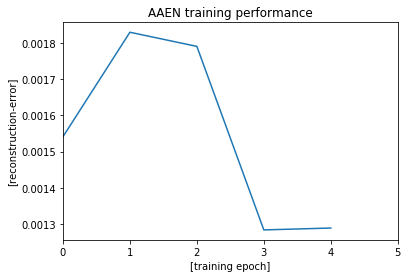

In [16]:
# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
# plt.ylim([0.0, 1.0])
plt.title('AAEN training performance')
plt.show()   
# mini_batch_losses.extend([reconstruction_loss.data[0]])
# plt.plot(range(0, len(mini_batch_losses)), mini_batch_losses)
# plt.xlim([0, len(mini_batch_losses)])
# plt.show()

# print(mini_batch_losses)

In [17]:
 # restore pretrained model checkpoint
encoder_model_name = "20180319-14_49_18_ep_20_encoder_model.pth"
decoder_model_name = "20180319-14_49_18_ep_20_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

# convert encoded transactional data to torch Variable
data = autograd.Variable(df_torch)

# set networks in training mode
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))
print(reconstruction.size())

# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.data[0]))

torch.Size([284807, 31])
[LOG 20180320-18:56:57] collected reconstruction loss of: 284807/284807 transactions
[LOG 20180320-18:56:57] reconstruction loss: 0.0008273241


[ 0.  0.  0. ...,  0.  0.  0.]
284807
[LOG 20180320-18:57:38] collected individual reconstruction loss of: 00000/284807 transactions
[LOG 20180320-18:57:42] collected individual reconstruction loss of: 100000/284807 transactions
[LOG 20180320-18:57:45] collected individual reconstruction loss of: 200000/284807 transactions
[[  0.00000000e+00   1.38189309e-04]
 [  1.00000000e+00   3.32497322e-04]
 [  2.00000000e+00   2.01872876e-03]
 ..., 
 [  2.84804000e+05   8.11289705e-04]
 [  2.84805000e+05   1.93396374e-03]
 [  2.84806000e+05   2.37891116e-04]]


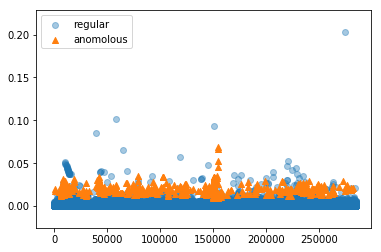

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])
print(reconstruction_loss_transaction)
print(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):  # iterate over 0 to 284807 transactions

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).data[0]
#   print(reconstruction_loss_transaction[i])

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:05}/{:05} transactions'.format(now, i, reconstruction.size()[0]))

# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))
# print(plot_data)
# obtain regular transactions as well as anomalies
regular_data = plot_data[[Class == 0]]
print(regular_data)
# print('regular_data:', regular_data)
anomalous_data = plot_data[[Class == 1]]
# print('anomalous_data:', anomalous_data)

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(anomalous_data[:, 0], anomalous_data[:, 1], c='C1', marker="^", label='anomolous') # plot anomolous transactions

# add plot legend of transaction classes
ax.legend(loc='best')
filename = 'test_' + str(i) + '.png'
fig.savefig(fname=filename)
plt.show()